# 패션 MNIST

In [6]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) =\
  keras.datasets.fashion_mnist.load_data()

keras.dataset.fashion_mnist 모듈 아래 load_data() 함수는  
친절하게 훈련 데이터와 테스트 데이터를 나누어 반환해준다.  

이 데이터는 각각 입력과 타깃의 쌍으로 되어있다.  
내려받은 데이터가 있는지 확인하기 위해서는 왼쪽의 폴더 아이콘을 클릭해서 sample_data 폴더 확인

In [7]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


train_input은 가로 28cm, 세로 28cm의 종이가 60000개 쌓여있다고 생각하면 쉽다.  
train_target은 정답지가 60000개가 있다고 생각하면 된다.  

In [8]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


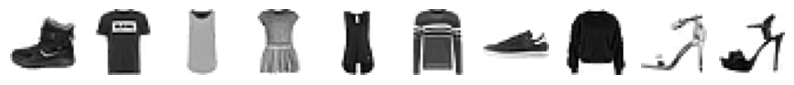

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize = (10, 10))

for i in range(10):
  axs[i].imshow(train_input[i], cmap = 'gray_r')
  axs[i].axis('off')

plt.show()

In [10]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패션 MNIST의 타깃은 0~9까지의 숫자 레이블로 구성된다.  
각 숫자의 의미는 아직 모르지만 마지막 2개의 샘플이 같은 레이블(숫자 5)을 가지고 있다.  
앞서 출력한 이미지를 보더라도 이 2개의 샘플은 같은 종류의 신발인 것을 알 수 있다.  
패션 MNIST에 포함된 10개의 레이블의 의미는 다음과 같다.  




0 : 티셔츠  
1 : 바지   
2 : 스웨터  
3 : 드레스  
4 : 코트  
5 : 샌달  
6 : 셔츠  
7 : 스니커즈  
8 : 가방  
9 : 앵클 부츠



In [11]:
import numpy as np

print(np.unique(train_target, return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


# 로지스틱 회귀로 패션 아이템 분류하기

이 훈련 샘플은 60,000개나 되기에 전체 데이터를 한꺼번에 사용하여 모델을 훈련하는 것보다 샘플을 하나씩 꺼내서 모델을 훈련하는 방법이 더 효율적이다.  
이런 상황에 잘 맞는 방법은 확률적 경사 하강법이다.  


In [12]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28 * 28)

reshape() 메서드의 두 번째 매개변수를 28 * 28 이미지 크기에 맞게 지정하면  
첫 번째 차원(샘플 개수)은 변하지 않고 원본 데이터의 두 번째, 세 번째 차원이 1차원으로 합쳐진다.  


In [13]:
print(train_scaled.shape)

(60000, 784)


SGDClassifier 클래스와 cross_validate() 함수를 사용해 이 데이터에서 교차 검증으로 성능 확인.

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss = 'log_loss', max_iter = 5, random_state = 42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)
print(np.mean(scores['test_score']))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


0.8196000000000001


반복 횟수를 늘려도 성능이 크게 향상되지는 않음.  


여기에서 4장에서 배웠던 로지스틱 회귀 공식을 생각해보자.  

z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f

이 식을 패션 MNIST 데이터에 맞게 변형하면 다음과 같다.  


z_티셔츠 = w1 * (픽셀 1) + w2 * (픽셀 2) + .. + w784 * (픽셀784) + b

총 784개의 픽셀, 즉 특성이 있으므로 아주 긴 식이 만들어진다.  
가중치 개수도 많아지기 때문에 a, b, c 대신에 w1, w2, w3과 같은 식으로 바꾸었다.

마지막에 절편 b를 더한다.  


z_바지 = w1' * (픽셀1) + w2' * (픽셀2) + ... + w784 * (픽셀 784) + b'

이 식은 티셔츠에 대한 선형 방정식과 매우 비슷하다.  
동일하게 784개의 픽셀값을 그대로 사용하고 있다.  
다만 바지에 대한 출력을 하기 위해서는 가중치와 절편은 다른 값을 사용해야한다.  

이 방정식의 계산은 다음과 같다.  

첫 번째 픽셀1이 w1과 곱해져서 z_티셔츠에 더해진다.  
두 번째 픽셀2도 w2와 곱해져서 z_티셔츠에 더해진다.  
마지막 픽셀784도 w784와 곱해져 z_티셔츠에 더하고 절편 b를 더한다.  
z_바지에 대해서도 동일하게 계산한다.  


티셔츠를 계산하기 위해 픽셀 784개와 곱하는 가중치 784개(w1 ~ w784)와 절편(b)이 바지를 계산하기 위해 픽셀 784개와 곱하는 가중치 784개 (w1' ~ w784'), 절편(b')과 다르다는 것이다.  


# 인공 신경망

인공신경망(Artificial neural network)

앞서 로지스틱 회귀를 표현한 그림과 매우 비슷하다.  

클래스가 총 10개이므로 z10까지 계산한다.  
z1 ~ z10을 계산하고 이를 바탕으로 클래스를 예측하기 때문에 신경망의 최종 값을 만든다는 의미에서 **출력층**이라고 한다.  


인공신경망에서는 z 값을 계산하는 단위를 **뉴런**이라고 한다.  
하지만 뉴런에서 일어나는 일은 선형 계산이 전부이다.  
이제는 뉴런이란 표현 대신 **유닛**이라고 부르는 사람도 있음.  

그 다음 픽셀1, 픽셀2를 x1, x2와 같이 바꾸었다.  
784번째 해당되는 x784까지 나타냈다.  
인공 신경망은 x1 ~ x784까지를 **입력층**이라고 한다.  


즉, 입력층은 픽셀값 자체이고 특별한 계산을 수행하지 않는다.  

인공 뉴런은 생물학적 뉴런에서 영감을 얻어서 만들어졌다.  
생물학적 뉴런은 수상 돌기로부터 신호를 받아 세포체에 모은다.  
신호가 어떤 임곗값에 도달하면 축삭 돌기를 통하여 다른 세포에 신호를 전달한다.  

그러나 생물학적 뉴런이 가중치와 입력을 곱하여 출력을 만드는 것은 아니다.  
4장에서 보았던 시그모이드 함수나 소프트맥스 함수를 사용하는 것은 아니다.  


## 텐서플로와 케라스

In [15]:
import tensorflow as tf

텐서플로에는 저수준 API와 고수준 API가 있다.  
바로 **케라스**가 텐서플로의 고수준 API이다.  


딥러닝 라이브러리가 다른 머신러닝 라이브러리와 다른 점 중 하나는 그래픽 처리 장치인 GPU를 사용하여 인공 신경망을 훈련한다는 것이다.  
GPU는 벡터와 행렬 연산에 매우 최적화되어 있기 때문에 곱셈과 덧셈이 많이 수행되는 인공 신경망에 큰 도움이 된다.  


케라스 라이브러리는 직접 GPU연산을 진행하지 않는다.  
대신 GPU 연산을 수행하는 다른 라이브러리를 **백엔드**로 사용한다.  
예를 들면 텐서플로가 케라스의 백엔드 중 하나이다.  


이외에도 씨아노, CNTK와 같은 여러 딥러닝 라이브러리를 케라스 백엔드롤 사용할 수 있다.  
이런 케라스를 멀티-백엔드 케라스라고 부른다.  

케라스 API만 익히면 다양한 딥러닝 라이브러리를 입맛대로 골라서 쓸 수 있다는 뜻이다.  
이를 위해 케라스는 직관적이고 사용하기 편한 고수준 API를 제공한다.  


In [16]:
from tensorflow import keras

# 인공신경망으로 모델 만들기

로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만,  
인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.  


이렇게 하는 이유는  
1. 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고,  
2. 교차 검증을 수행하기에는 훈련 시간이 너무 오래 걸리기 때문이다.  


In [17]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state = 42
)

In [18]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [19]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


케라스의 레이어(keras.layers) 패키지 안에는 다양한 층이 준비되어 있다.  
가장 기본이 되는 층은 **밀집층**이다.  
또는 양쪽의 뉴런이 모두 연결하고 있기 때문에 **완전 연결층**이라고도 부른다.  


케라스의 Dense 클래스를 사용해 밀집층을 만들어보자.  
필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기이다.  


In [20]:
dense = keras.layers.Dense(10, activation = 'softmax', input_shape=(784,))

첫 번째 매개변수로 뉴런 개수를 10개를 지정한다.  
10개의 패션 아이템을 분류하기 때문이다.  
두 번째 매개변수로 10개의 뉴런에서 출력되는 값을 확률로 바꾸기 위해서는
소프트맥스 함수를 사용한다. 만약 2개의 클래스를 분류하는 이진 분류라면 시그모이드 함수를 사용하기 위해 activation = 'sigmoid'와 같이 설정하면 된다.  



마지막으로 세 번째 매개변수는 입력값의 크기이다.  
10개의 뉴런이 각각 몇 개의 입력을 받는지 튜플로 지정한다.  
여기에서는 784개의 픽셀값을 받는다.  

이러면 신경망 층을 만든 것이다.  


이제 이 밀집층을 가진 신경망 모델을 만들어야 한다.  
케라스의 Sequential 클래스를 사용.  


In [21]:
model = keras.Sequential(dense)

Sequential 클래스의 객체를 만들 때 앞에서 만든 밀집층의 객체 dense를 전달.  
여기서 만든 model 객체가 바로 신경망 모델이다.  


절편이 뉴런마다 더해진다.  
소프트맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 **활성화 함수**라고 부른다.  

참고: 소프트맥수 함수는 별도의 층인가?  
시그모이드 함수나 소프트스와 같은 활성화 함수는 뉴런의 출력에 바로 적용되기 때문에 보통 층의 일부로 나타난다.  
하지만 종종 "소프트맥스 층을 적용했어"와 같이 따로 부르는 경우도 많다.  
가중치와 절편으로 선형 계산을 수행하는 층을 좁은 개념의 신경망 층으로 생각한다면 소프트맥스 층은 넓은 의미의 층이라고 부를 수 있다.  


# 인공 신경망으로 패션 아이템 분류하기  

케라스 모델을 훈련하기 전에 설정 단계가 있다.  
이런 설정을 model 객체의 complie() 메서드에서 수행한다.  
꼭 지정해야할 것은 손실 함수의 종류이다.  그 다음 훈련 과정에서 계산하고 싶은 측정값을 지정한다.  


In [24]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

이진 분류에서는 이진 크로스 엔트로피 손실 함수를 사용한다.  
다중 분류에서는 크로스 엔트로피 손실 함수를 사용한다.  
케라스에서는 이 두 손실 함수를 'binary_crossentropy', 'categorical_crossentropy'로 나누어 부른다.  


*   이진 분류: loss = 'binary_crossentropy'
*   다중 분류: loss = 'categorical_crossentropy'



sparse란 단어는 왜 붙었는가?

그 이유를 알기 전에 4장의 내용을 다시 기억해보자.  
이진 크로스 엔트로피 손실을 위해 -log(예측 확률)에 타깃값(정답)을 곱했다.  


출력층
- a = a = -log(a) * 타깃값 >>> 타깃값이 1일 때, 즉 양성 샘플일 때
- a = 1 - a = -log(1 - a) * (1 - 타깃값) >>> 타깃값이 0일 때, 즉 음성 샘플일 때

이진 분류에서는 출력층의 뉴런이 하나이다.  
이 뉴런이 출력하는 확률값 a(시그모이드 함수의 출력값)를 사용해 양성 클래스와 음성 클래스에 대한 크로스 엔트로피를 계산한다.  
이 계산은 4장에서 본 로지스틱 손실 함수와 동일하다.  


이진 분류의 출력 뉴런은 오직 양성 클래스에 대한 확률(a)만 출력하기 때문에 음성 클래스에 대한 확률은 간단히 1 - a로 구할 수 있다.  
이진 분류의 타깃값은 양성 샘플일 경우 1, 음성 샘플일 경우에는 0으로 되어 있다.  
0을 곱하면 어떤 계산이든지 모두 0이 되기 때문에 특별히 음성 샘플이 경우 1로 바꾸어 (1 - 타깃값)을 계산한다.  
이렇게 하면 하나의 뉴런만으로 양성과 음성 클래스에 대한 크로스 엔트로피 손실을 모두 계산할 수 있다.  

그럼 MNIST 데이터셋과 같이 다중 분류일 경우에는 어떻게 계산하는가?  


출력층은 10개의 뉴런이 있고 10개의 클래스에 대한 확률을 출력한다.  
첫 번째 뉴런은 티셔츠일 확률이고 두 번째 뉴런은 바지일 확률을 출력한다.  
이진 분류와 달리 각 클래스에 대한 확률이 모두 출력되기 때문에 타깃에 해당하는 확률만 남겨 놓기 위해서 나머지 확률에는 모두 0을 곱한다.  


예를 들어 샘플이 티셔츠일 경우 첫 번째 뉴런이 활성화 함수 출력인 a1에 크로스 엔트로피 손실 함수를 적용하고 나머지 활성화 함수 출력 a2 ~ a10까지는 모두 0으로 만든다.  
이렇게 하기 위해서 티셔츠 샘플의 타깃값은 첫 번째 원소만 1이고 나머지는 모두 0인 배열로 만들 수 있다.  
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


이 배열과 출력층의 활성화 값의 배열과 곱하면 된다.  
[a1, a2, a3, a4, a5, a6, a7, a8, a9, a10] * [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

길이가 가튼 넘파이 배열의 곱셈은 원소별 곱셈으로 수행된다.  
즉, 배열에서 동일한 위치의 원소끼리 곱셈이 된다.  
결국 다른 원소는 모두 0이 되고 a1만 남게 되는 것이다.  

신경망은 티셔츠 샘플에서 손실을 낮추려면 첫 번째 뉴런의 활성화 출력 a1의 값을 가능한 1에 가깝게 만들어야 한다.  


두 번째 뉴런의 활성화 출력인 a2만 남기려면 두 번째 원소만 1이고 나머지는 모두 0으로 타깃값을 준비하면 된다.  
바지 샘플을 정확하게 분류하려면 신경망이 a2의 출력을 가능한 한 높여야 한다.  


이와 같이 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것을 **원 - 핫 인코딩**이라고 한다.  

따라서 다중 분류에서 크로스 엔트로피 손실 함수를 사용하려면 0, 1, 2와 같이 정수로 된 타깃값을 원 - 핫 인코딩으로 변환해야 한다.  

그런데 패션 MNIST 데이터의 타깃값을 확인해보면

In [25]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


모두 정수로 되어 있다.  
하지만 텐서플로에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 사용할 수 있다.  
정수로 된 타깃값을 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 'sparse_categorical_crossentropy'이다.  
빽빽한 배열 말고 정숫값 하나만 사용한다는 뜻에서 sparse(희소)라는 이름을 붙였다.  
타깃값을 원-핫 인코딩으로 준비했다면 compile()메서드에 손실 함수를 loss = 'categorical_crossentropy'로 지정한다.  


두 번째 매개변수인 metrices에 대해 알아보자.  
케라스는 모델이 훈련할 때 기본으로 에포크마다 손실 값을 출력해준다.  
손실이 줄어드는 것을 보고 훈련이 잘 되었다는 것을 알 수 있지만 정확도를 함께 출력하면 좋을 것이다.  
이를 위해 metrices 매개변수에 정확도 지표를 의미하는 'accuracy'를 지정했다.


모델 훈련

In [26]:
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 2ms/step - loss: 0.6104 - accuracy: 0.7904
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4741 - accuracy: 0.8395
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4502 - accuracy: 0.8466
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4382 - accuracy: 0.8518
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4280 - accuracy: 0.8551


케라스는 친절하게 에포크마다 걸린 시간과 손실(loss), 정확도(accuracy)를 출력해준다.  
5번 반복에 정확도가 85%를 넘었다.  
따로 떼어 놓은 검증세트(val_scaled, val_target)에서 모델의 성능 확인.  


In [27]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4411 - accuracy: 0.8487


[0.44114431738853455, 0.8486666679382324]

evaluate() 메서드도 fit() 메서드와 비슷한 출력을 보여준다.  
검증 세트의 점수는 훈련 세트의 점수보다 조금 낮은 것이 일반적이다.  
예상대로 평가 결과는 훈련 세트의 점수보다 조금 낮은 84% 정도의 정확도를 냈다.  


# 정리

In [28]:
# 사이킷런 모델

# 모델
sc = SGDClassifier(loss = 'log_loss', max_iter = 5)

# 훈련
sc.fit(train_scaled, train_target)

# 평가
sc.score(val_scaled, val_target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.82

In [31]:
# 케라스 모델

dense = keras.layers.Dense(10, activation = 'softmax', input_shape = (784,))

# 모델
model = keras.Sequential(dense)
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

# 훈련
model.fit(train_scaled, train_target, epochs = 5)

# 평가
model.evaluate(val_scaled, val_target)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6018 - accuracy: 0.7952
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4738 - accuracy: 0.8396
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4514 - accuracy: 0.8469
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4385 - accuracy: 0.8519
Epoch 5/5
375/375 [==============================] - 1s 2ms/step - loss: 0.4388 - accuracy: 0.8503


[0.4388004243373871, 0.8502500057220459]